**Introduction**

I will train the ResNet18 neural network on a selection of MNIST data available at Google Colab using PyTorch. I will use data augmentation technique to improve the models performance.

I start with loading general python modules (numpy, panadas, pytorch) and my own module. My module is downloaded from github and saved in local directory. On Google Colab the file location is '/content/src/mnist.py'. It contains the code for my PyTorch implementation of the model, dataset and training loop. In the next section I will train the ResNet18 model.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import subprocess
import torch
import torchvision


In [2]:
overwrite=False
!mkdir -p ./src
!mkdir -p ./saved_models
src_directory=os.getcwd()+'/src'
src_file=src_directory+'/mnist.py'
if(overwrite): 
    subprocess.call(['wget','https://raw.githubusercontent.com/Marcin-Kisielowski/MNIST/main/src/mnist.py','-O',str(src_file)])
else:
    subprocess.call(['wget','-nc','https://raw.githubusercontent.com/Marcin-Kisielowski/MNIST/main/src/mnist.py','-O',str(src_file)])
sys.path.append(src_directory)
import mnist
%matplotlib inline

Training on device  cuda


In [3]:
train_data_path=os.getcwd()+'/sample_data/mnist_train_small.csv'
if not os.path.exists(train_data_path):
    print("Could not locate train data at %s."%train_data_path)
test_data_path=os.getcwd()+'/sample_data/mnist_test.csv'
if not os.path.exists(test_data_path):
    print("Could not locate test data at %s."%train_data_path)


In [4]:
test_data=mnist.MNISTdigits(test_data_path)

**Training ResNet18 model**

I will use the steepest gradient descent method with learning rate adjusted by hand (SGD optimizer). In each training step I train the model for 10 epochs (batch size 16). This is done when the function mnist.analyze_model(resnet,16,10) is called. Calling mnist.analyze_model(resnet,16,10) twice results in training the model for 20 epochs, etc. After each training step I plot the values of the training and validation losses after each epoch.

In [5]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
resnet.load_data(train_data_path,split_ratio)

training time: 120.939469 	 train accuracy: 0.998688 	 valid accuracy: 0.990000 


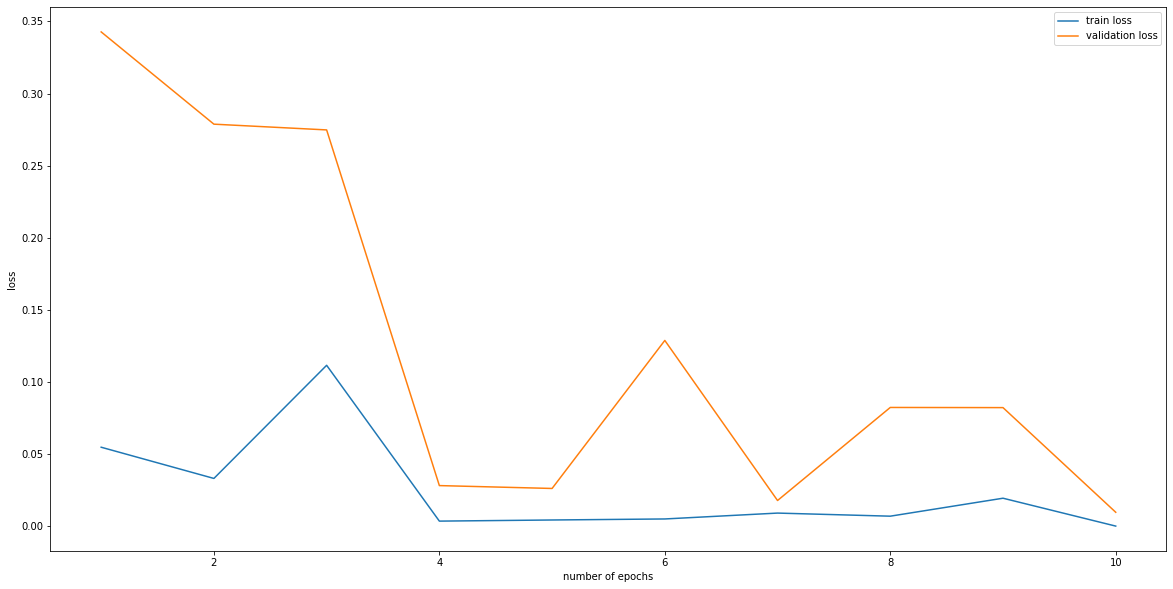

In [6]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 119.986665 	 train accuracy: 0.998375 	 valid accuracy: 0.988500 


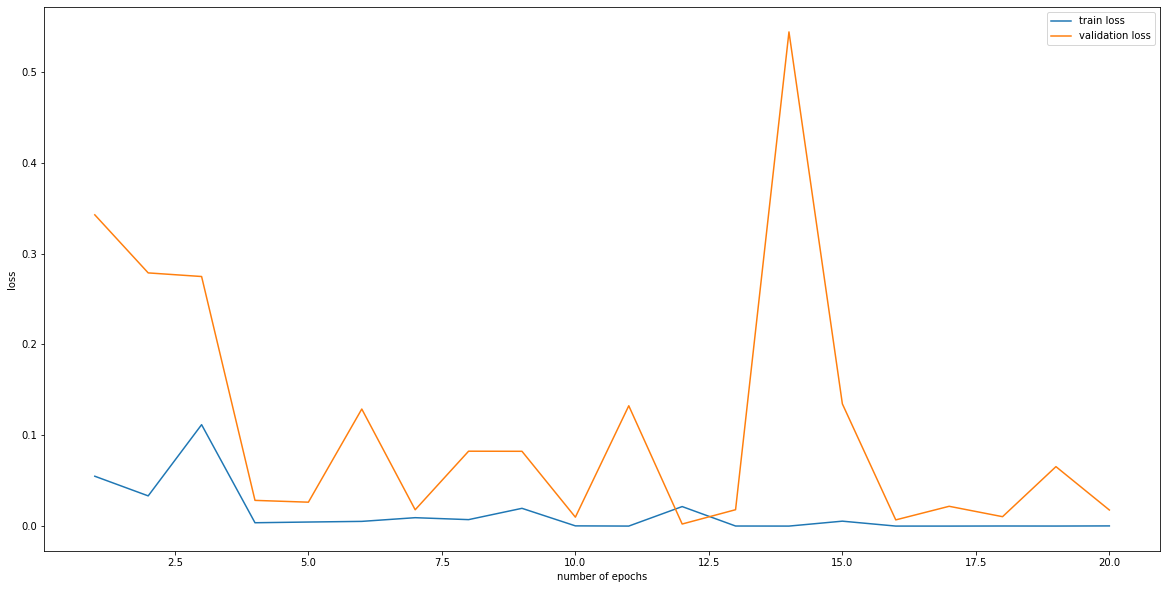

In [7]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 120.487610 	 train accuracy: 1.000000 	 valid accuracy: 0.992250 


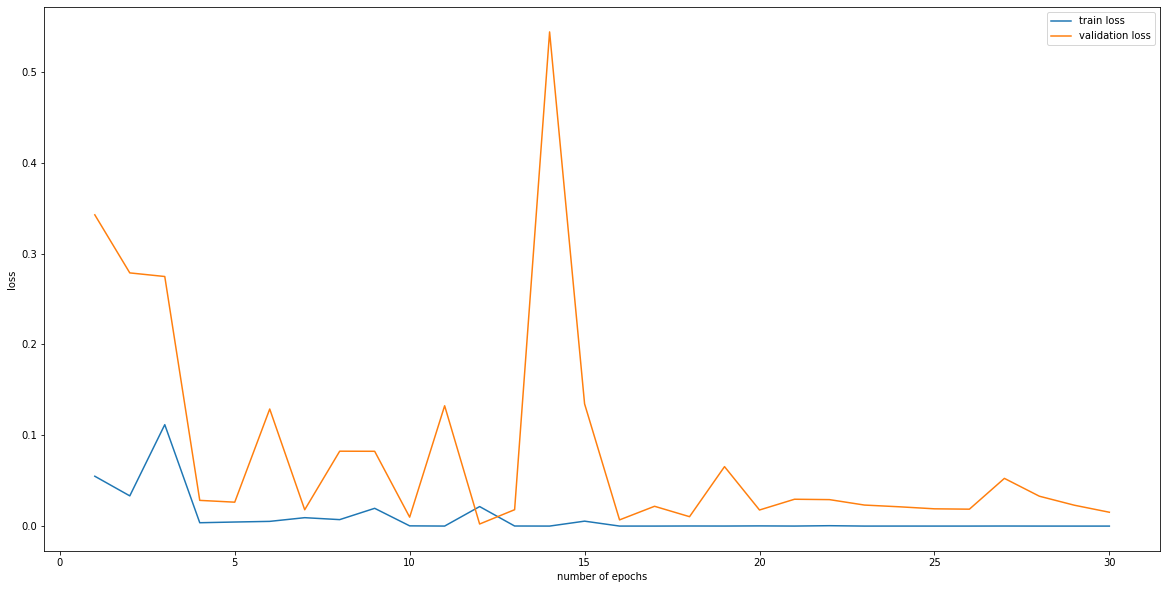

In [8]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

After 30 epochs the training accuracy is 1.0. The validation accuracy is highest when train accuracy is 1.0. This is a signal that we can do better by using more data. Generally, we would look for more training data when the train error is below our goal and the validation error is above our goal (see https://www.cs.cornell.edu/courses/cs4780/2021fa/lectures/lecturenote12.html for more details). Here the gap between the train accuracy and validation accuracy is very small but the results in Kaggle competition suggest that we can indeed do better. Instead of the small selection of data on google colab we could use the full data for example from torchvision.datasets.MNIST. For educational reasons (and having Kaggle competition in mind) I choose to create artificial data by applying random shear and rotation to the images in the small dataset. Let us measure the test accuracy and continue with testing different augmentation parameters.

In [9]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.991100


**Data augmentation: rotation**

I will build twice bigger training dataset by creating artifical data. In order to create the artificial data I will apply transformations, which in this section are random rotations in the range of -10 to 10 degrees. This is done with resnet.load_data(train_data_path,split_ratio,2,transformation). The number 2 indicates that the augmented train set will be twice bigger that the original train set.

In [12]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
transformation=torchvision.transforms.RandomAffine(degrees=(-10,10))
resnet.load_data(train_data_path,split_ratio,2,transformation)

training time: 287.110653 	 train accuracy: 0.995750 	 valid accuracy: 0.985250 


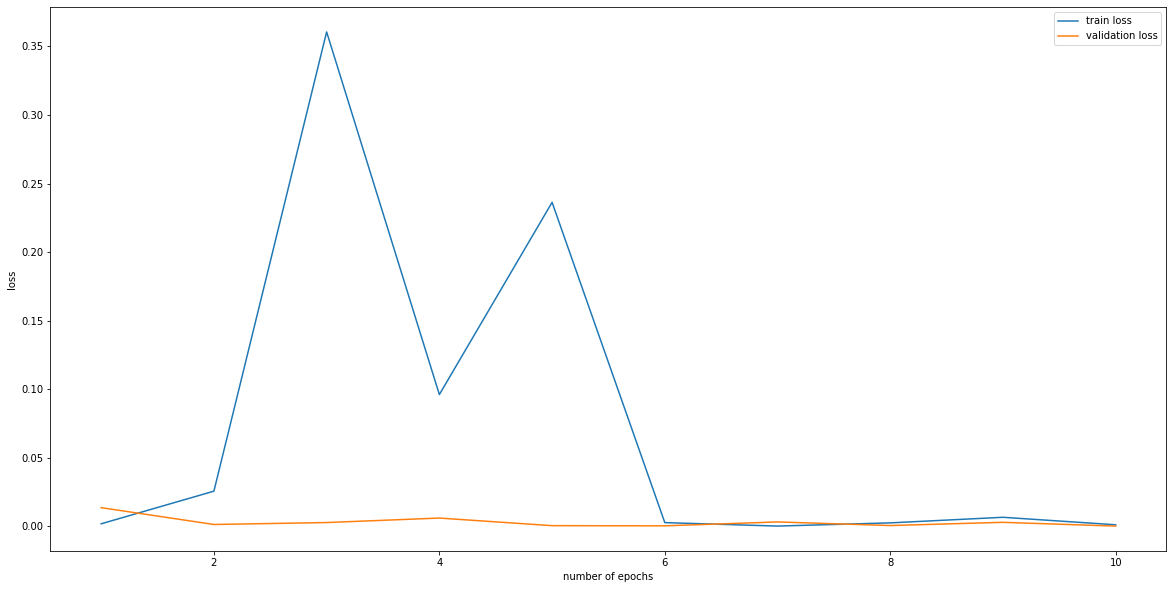

In [11]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 287.382779 	 train accuracy: 0.999250 	 valid accuracy: 0.990250 


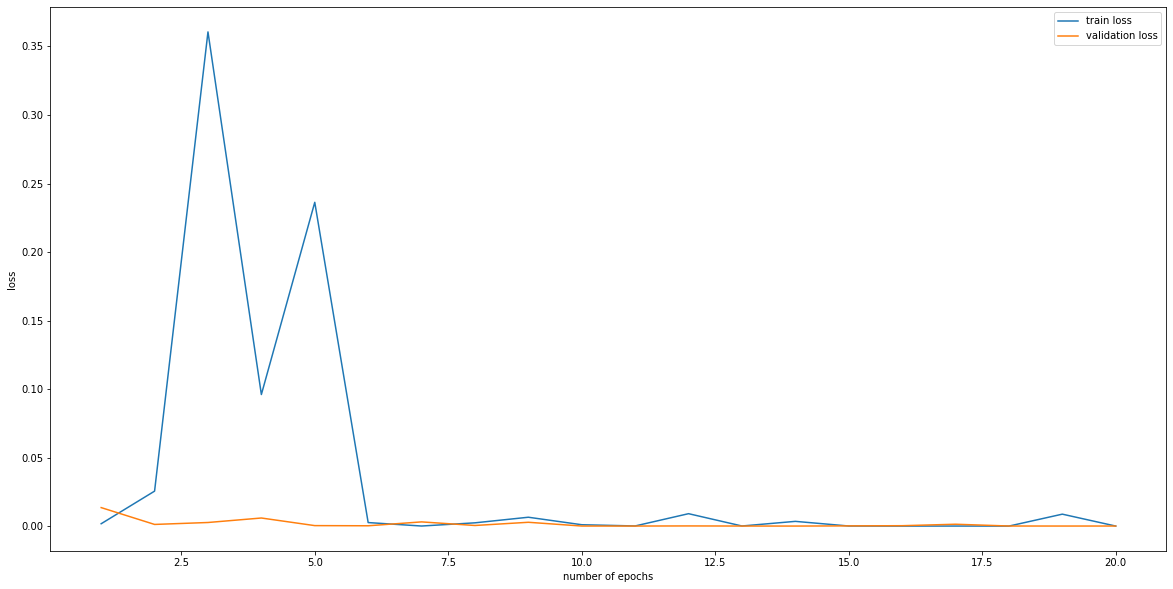

In [12]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 285.055895 	 train accuracy: 1.000000 	 valid accuracy: 0.993000 


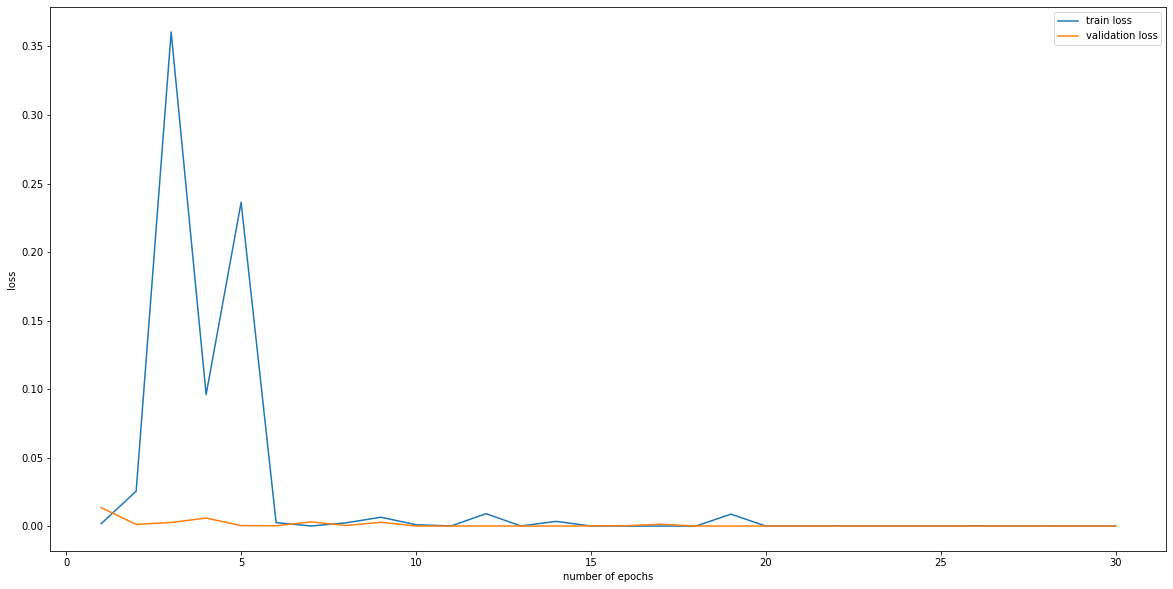

In [13]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [14]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.992700


**Data augmentation: shear**

In this section I will try another augmentation method: I will apply random shear.

In [13]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
transformation=torchvision.transforms.RandomAffine(degrees=0,shear=(-15,15))
resnet.load_data(train_data_path,split_ratio,2,transformation)

training time: 272.424516 	 train accuracy: 0.998844 	 valid accuracy: 0.985750 


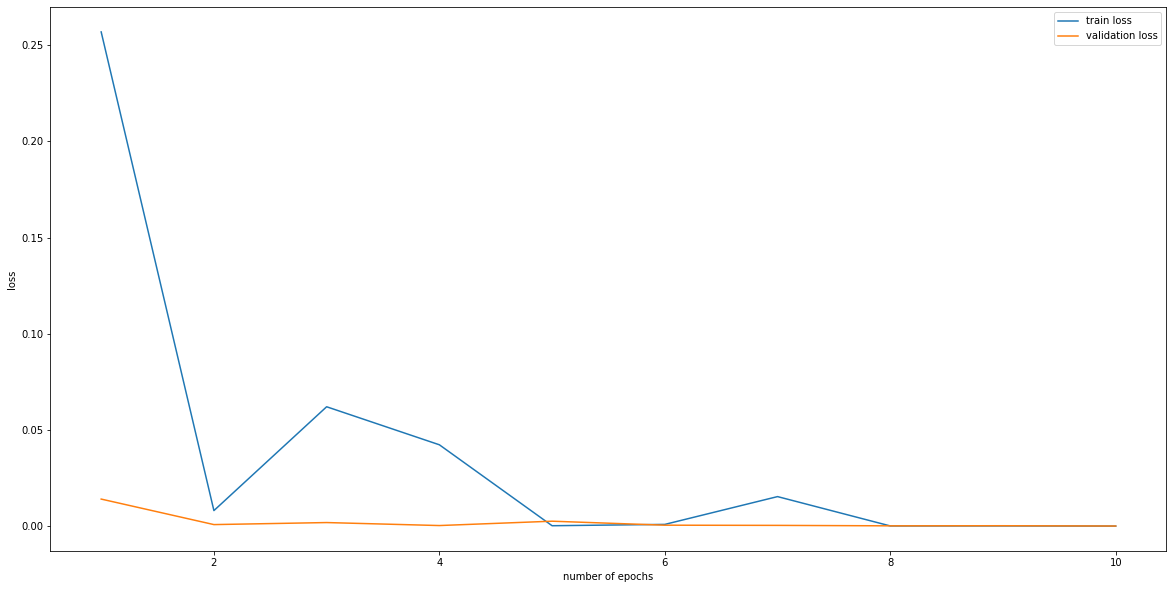

In [14]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 269.835493 	 train accuracy: 0.999719 	 valid accuracy: 0.987500 


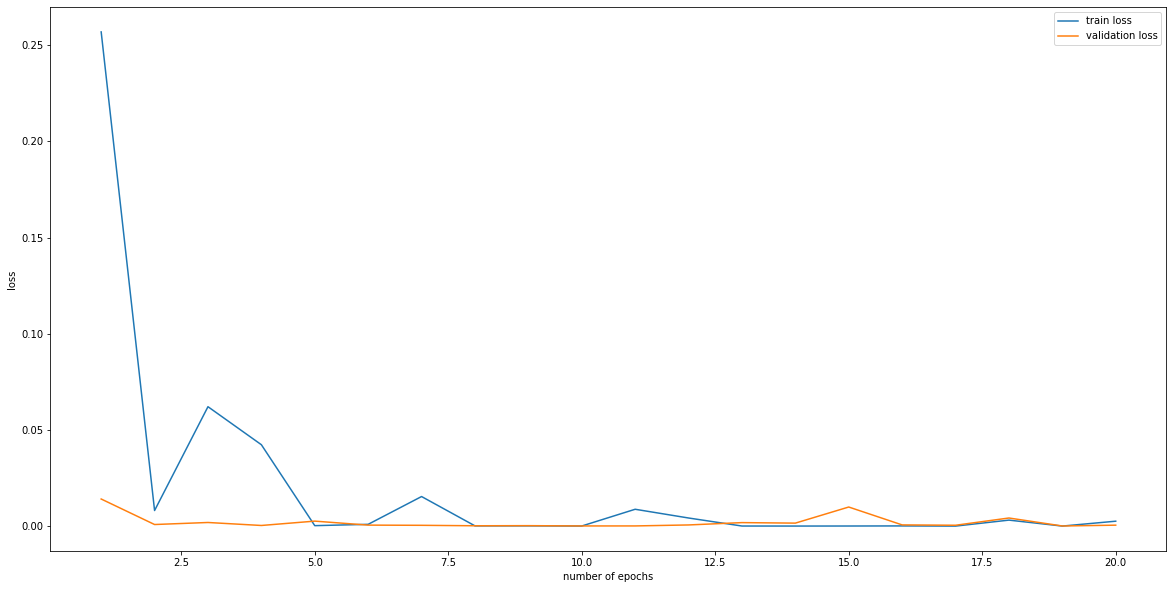

In [15]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 271.716708 	 train accuracy: 0.999969 	 valid accuracy: 0.989500 


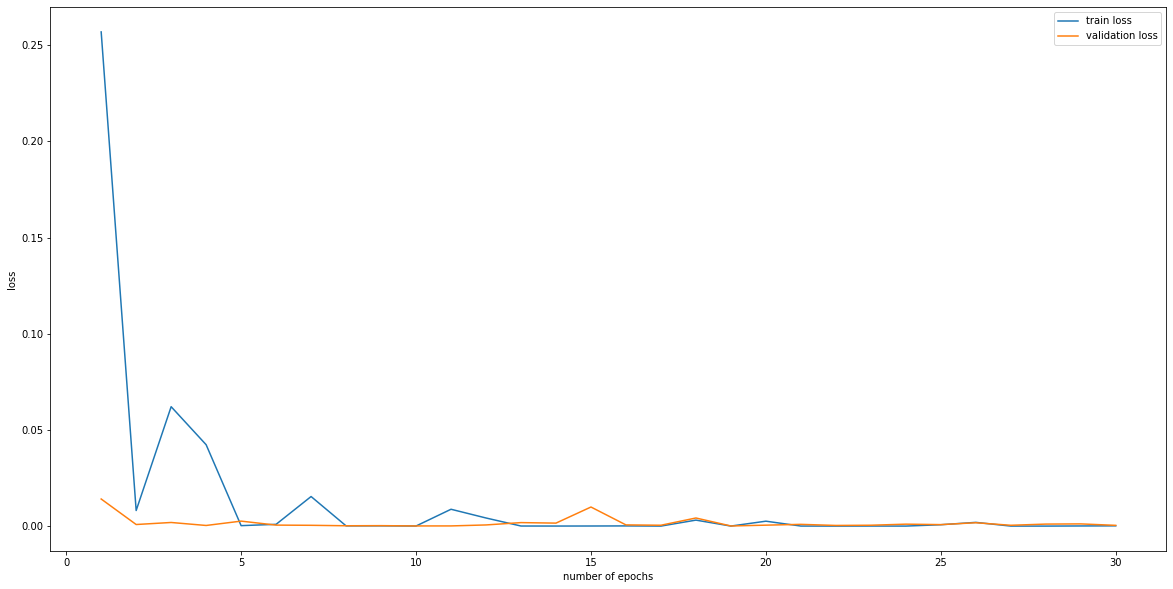

In [16]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 273.611339 	 train accuracy: 0.999938 	 valid accuracy: 0.989750 


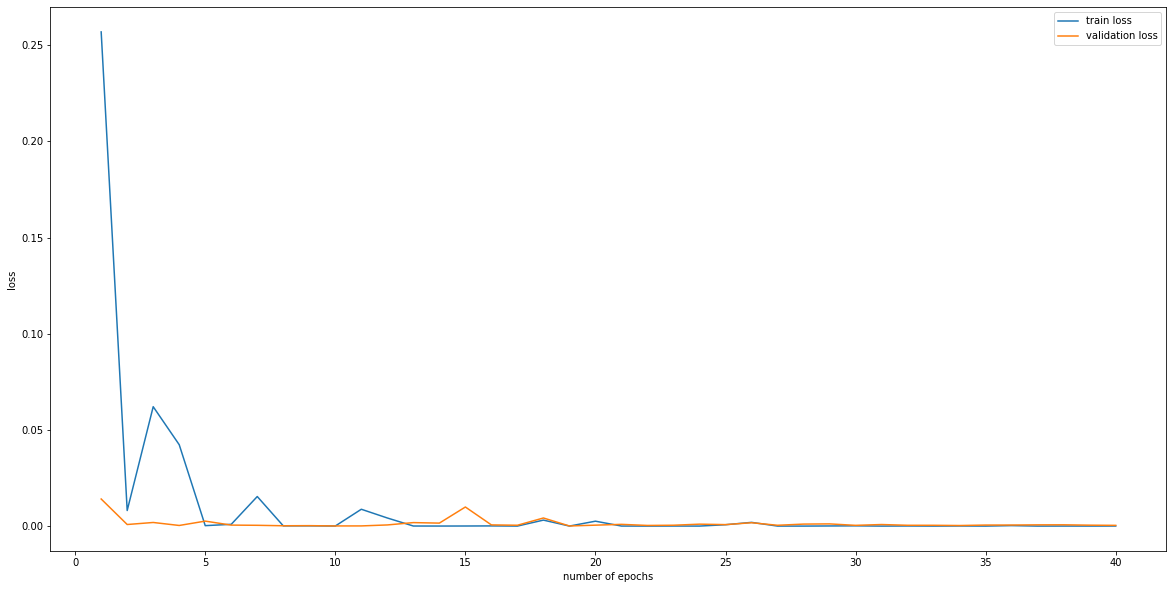

In [17]:
learning_rate=1.0e-03
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 276.093696 	 train accuracy: 1.000000 	 valid accuracy: 0.989500 


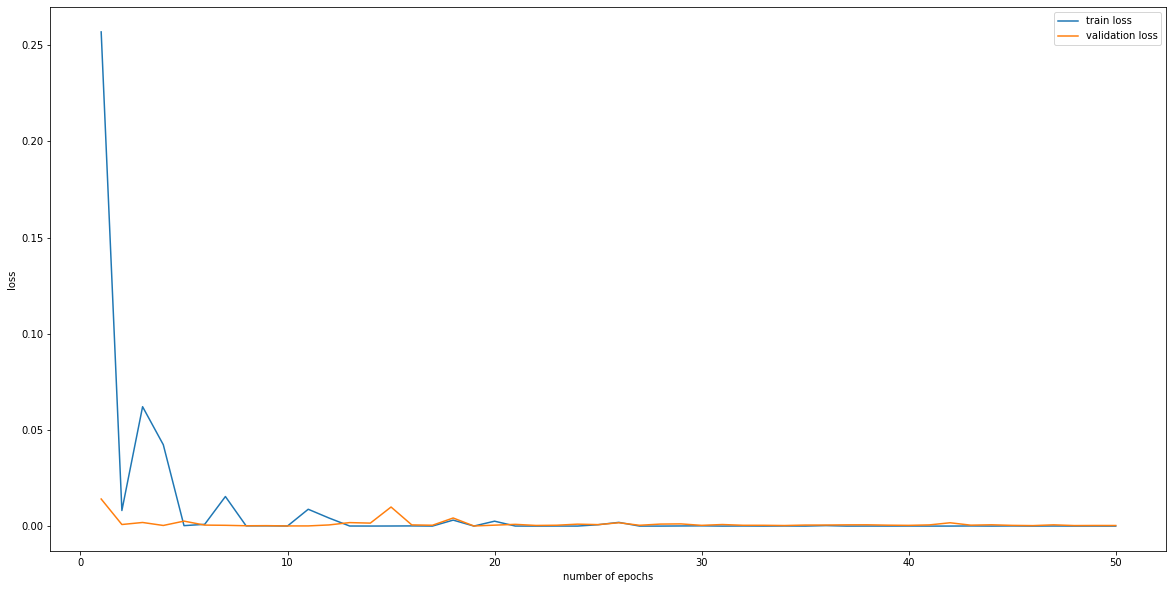

In [18]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [19]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.993200


**Data augmentation: shear + rotation**

In this section I will apply random rotations in the range of -10 to 10 degrees and random shears in the range of -15 to 15 degrees.

In [32]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
transformation=torchvision.transforms.RandomAffine(degrees=(-10,10),shear=(-15,15))
resnet.load_data(train_data_path,split_ratio,2,transformation)

training time: 271.599299 	 train accuracy: 0.996406 	 valid accuracy: 0.989250 


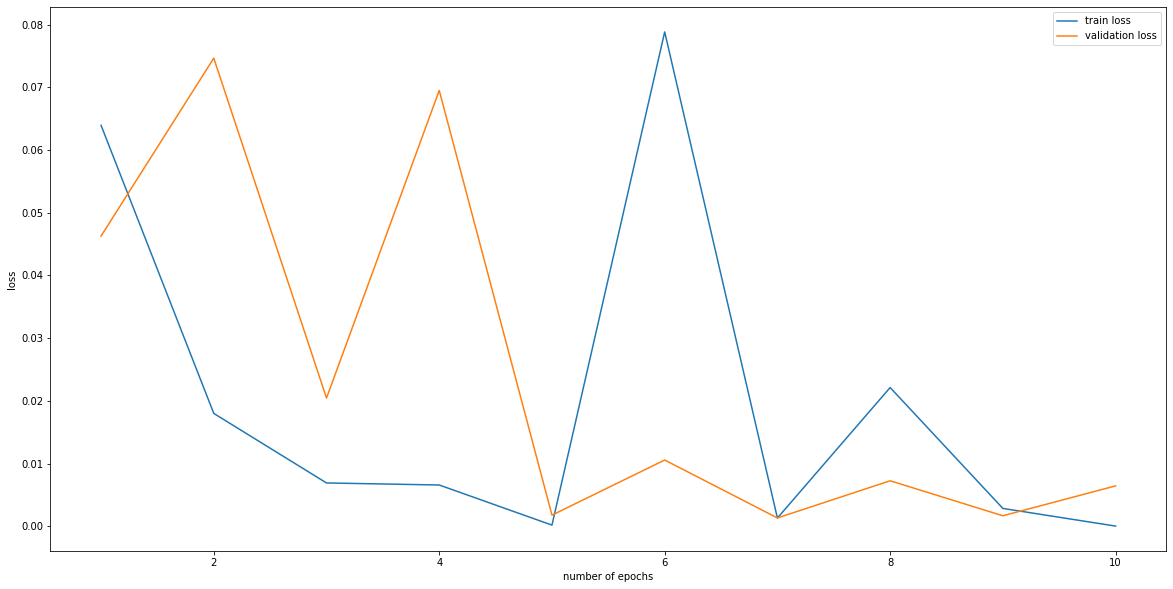

In [33]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 276.440108 	 train accuracy: 0.997969 	 valid accuracy: 0.990500 


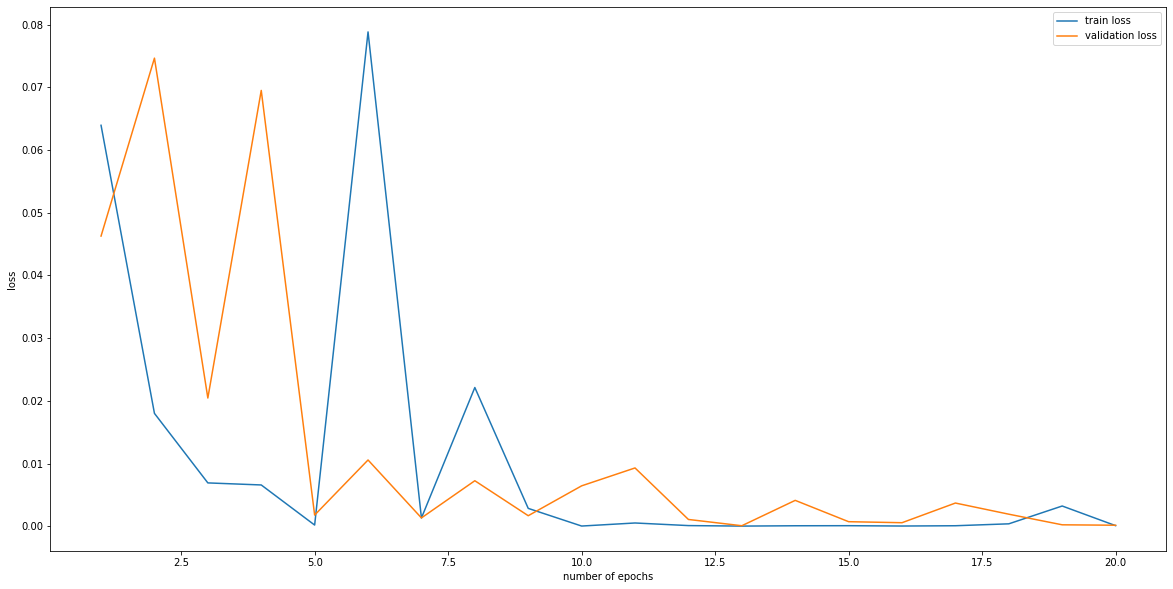

In [34]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 272.260421 	 train accuracy: 0.999281 	 valid accuracy: 0.990250 


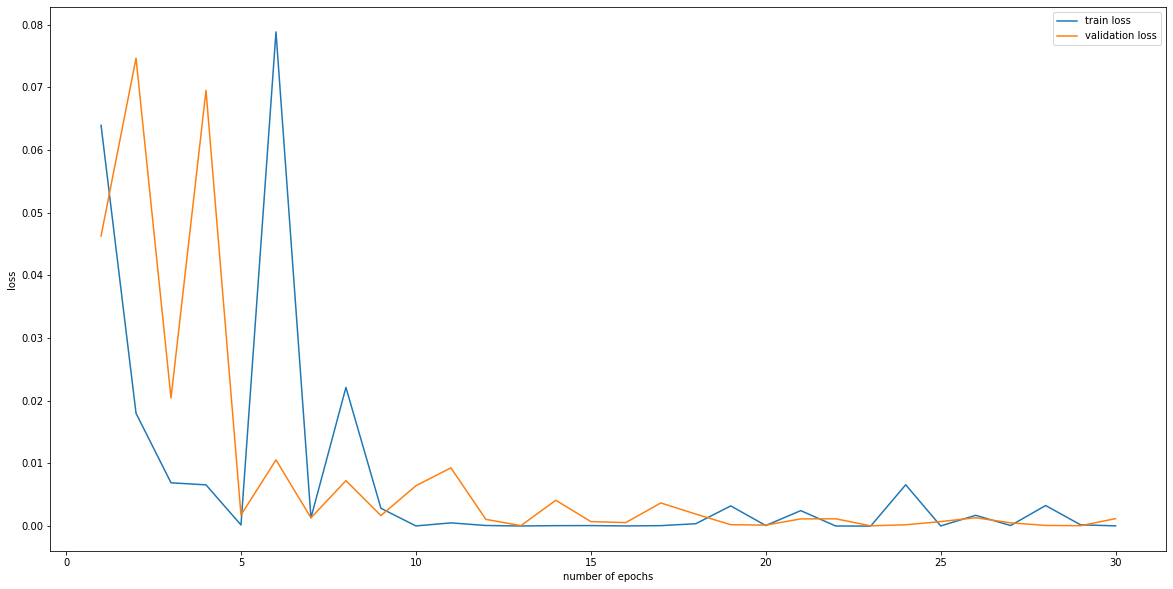

In [35]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [ ]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 275.111770 	 train accuracy: 0.999531 	 valid accuracy: 0.990250 


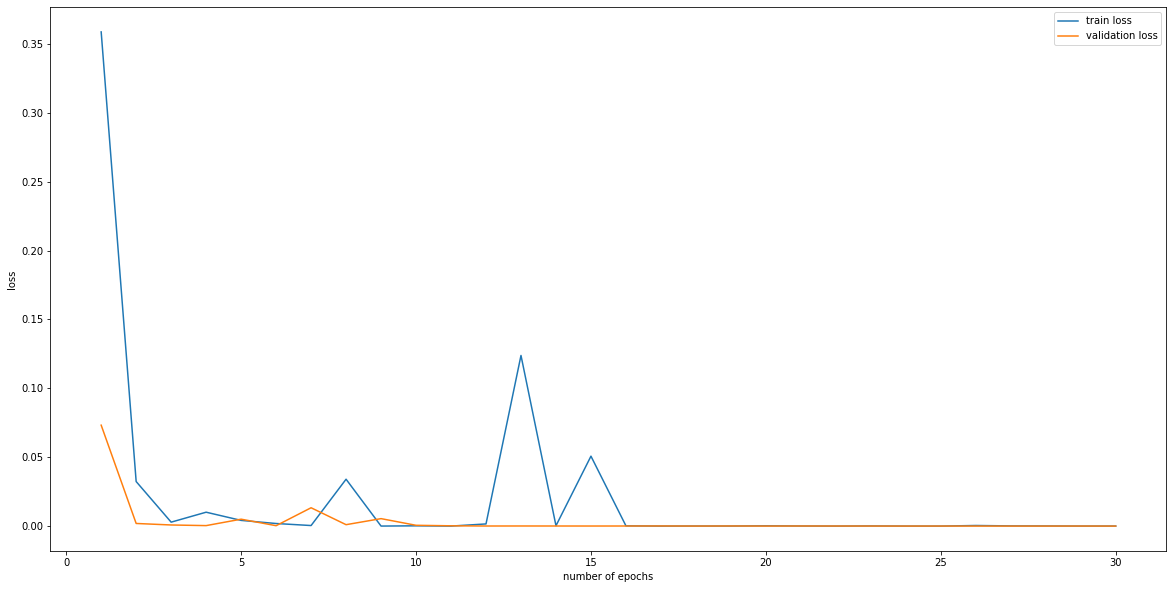

In [23]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 273.204559 	 train accuracy: 0.999844 	 valid accuracy: 0.990500 


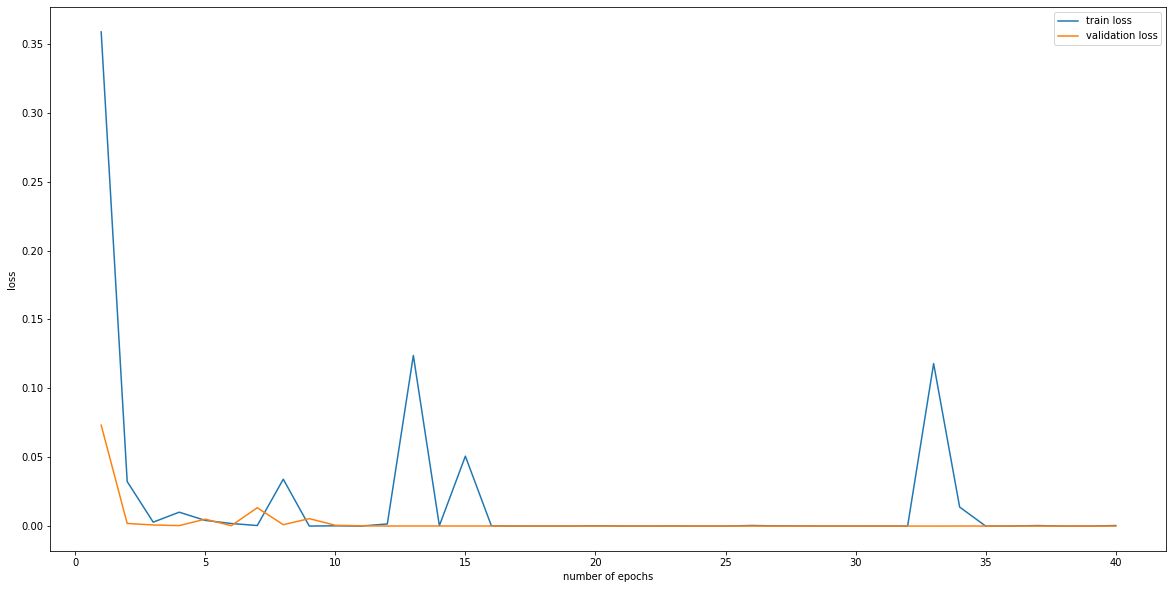

In [24]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 271.395562 	 train accuracy: 0.999719 	 valid accuracy: 0.991000 


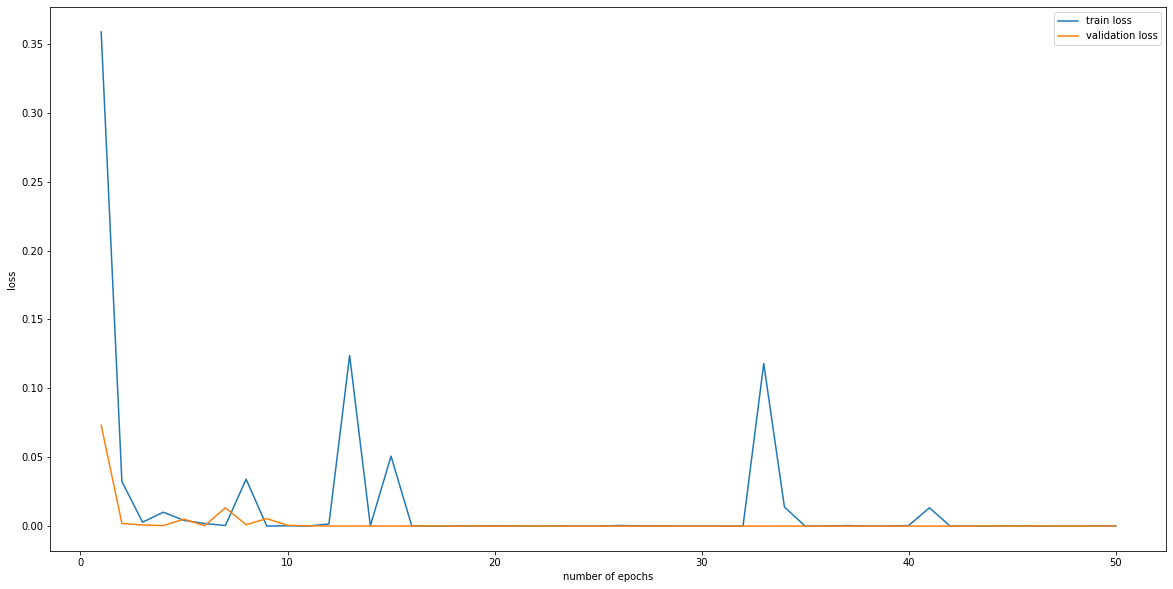

In [25]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [26]:
resnet.save_parameters("_augmentation_ratio_2_rotation_10_shear_15")

In [27]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.992600


training time: 272.795481 	 train accuracy: 0.999781 	 valid accuracy: 0.990750 


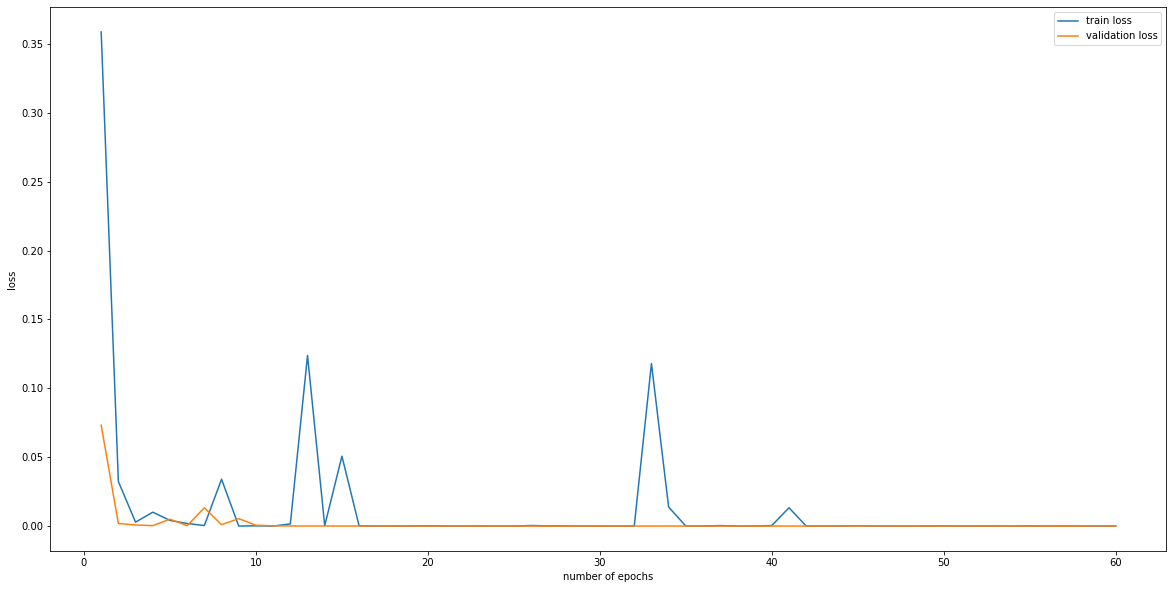

In [28]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [29]:
resnet.save_parameters("_augmentation_ratio_2_rotation_10_shear_15")
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.992700


training time: 276.069161 	 train accuracy: 1.000000 	 valid accuracy: 0.990500 


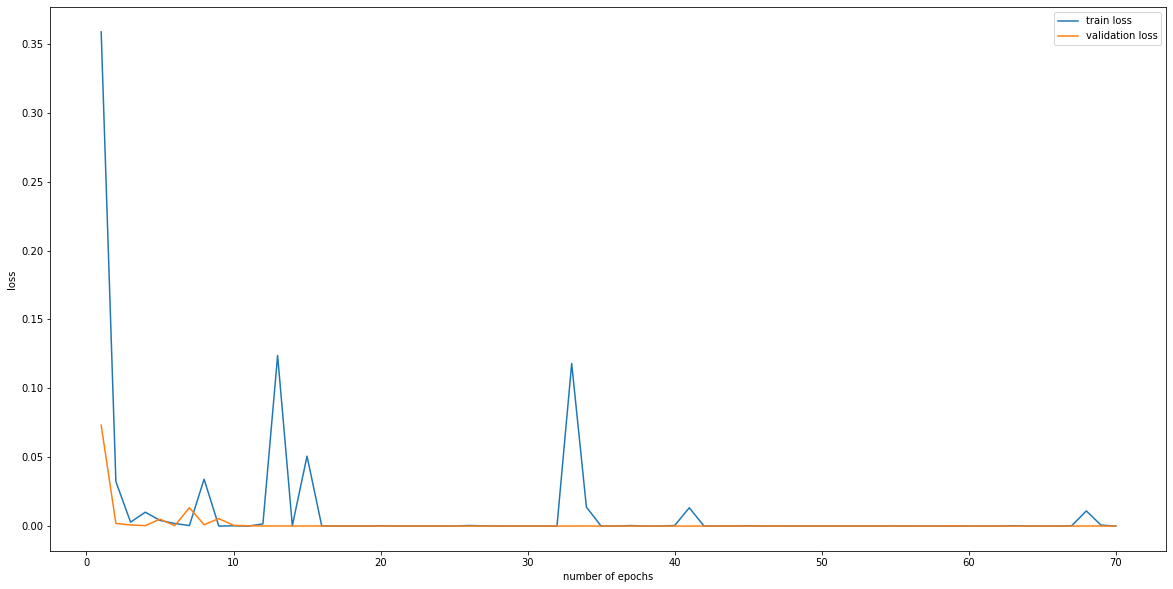

In [30]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [31]:
resnet.save_parameters("_augmentation_ratio_2_rotation_10_shear_15")
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.992800


**Conclusions**

By looking at the validation results we conclude that data augmentation leads to an improvement in our model. Let us underline that we make the decision which model to use basing on train and validation scores. The test scores are for educational reasons and debugging. The test scores are close to validation scores so there the validation set is chosen properly, in particular it is representative and there is no data leakage. 